In [1]:
import tensorflow as tf
#tf.enable_eager_execution()
from os import listdir
from os.path import isfile, join
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
%load_ext pycodestyle_magic

### Parameters

In [2]:
FEAT_DIR = './data/train/images'
LABELS_DIR = './data/train/masks'
#VGG_PATH = '/home/paperspace/kaggle/Semantic_Segmentation/vgg16/saved_model_with_dropout'
VGG_PATH = '/home/paperspace/kaggle/Semantic_Segmentation/vgg16/saved_model_no_weights'
NUM_CLASSES = 1
LRATE = 0.001
EPOCHS = 10
BATCH_SIZE = 64
IMAGE_SHAPE = (101, 101, 3)
LABEL_SHAPE = (101, 101)
INPUT_SHAPE = (104, 104, 3)
OUTPUT_SHAPE = (104, 104)
# input different to the image dimensions due to a hack to make the layers symmetric when
# deconvoluting


### data get

In [3]:
#%%pycodestyle

class data_handling:
    
    def __init__(self, feat_path=FEAT_DIR, label_path=LABELS_DIR):
        self.create_arrays(feat_path, label_path)
        self.train_feat_data, \
        self.val_feat_data, \
        self.test_feat_data, \
        self.train_feat_data_filenames, \
        self.val_feat_data_filenames, \
        self.test_feat_data_filenames \
        = \
        self.split_data(self.feat_data, 
                        self.filenames)
        
        self.train_label_data, \
        self.val_label_data, \
        self.test_label_data, \
        _, _, _ = \
        self.split_data(self.label_data, 
                        self.filenames)
    
    def gen_batch_function(self, dataset='train',
                           bs=BATCH_SIZE, num_batches=None):
        
        if dataset == 'train':
            feat = self.train_feat_data
            labels = self.train_label_data
            
        elif dataset == 'test':
            feat = self.test_feat_data
            labels = self.test_label_data
            
        if num_batches is None:
            stop_iter = len(feat)//bs + 1
        else:
            stop_iter = num_batches
        
        batch = 0
        
        for i in range(stop_iter):
            if batch != len(feat)//bs:
                
                st = batch*bs; end = (batch+1)*bs;
                
                yield (feat[st:end,:].astype('float32')\
                - self.get_mean()), \
                labels[st:end,:].astype('float32')
                
                batch += 1
            else:
                yield feat[batch*bs:(len(feat)),:].astype('float32')\
                 - self.get_mean(), \
                labels[batch*bs:(len(feat)),:].astype('float32')

    def create_arrays(self, feat_path, label_path):
        
        files = [f for f in \
                       listdir(feat_path) if isfile(join(feat_path, f))]

        feat_data = np.zeros((len(files), *INPUT_SHAPE)).astype('int')
        label_data = np.zeros((len(files), *OUTPUT_SHAPE)).astype('int')
            
        for i in range(len(files)):
            feat_data[i,
                 :IMAGE_SHAPE[0],
                 :IMAGE_SHAPE[1],
                 :] = np.array(Image.open(feat_path + '/'+ files[i])) 
            label_data[i,
                 :IMAGE_SHAPE[0],
                 :IMAGE_SHAPE[1]
                ] = np.array(Image.open(label_path + '/'+ files[i]))                
        
        self.feat_data, self.label_data, self.filenames = self.shuffle(feat_data,
                                                 label_data,
                                                 pd.Series(files))
        
        self.label_data = self.label_data/65535.0
        
        return None
    
    @staticmethod
    def split_data(data, \
                   filenames, \
                   val_split = 0.05,
                   split = 0.8
                  ):
        
        train_end = int(len(data)*(split - val_split))
        val_end = int(len(data)*split)

        train_feat = data[:train_end]
        train_feat_filenames = filenames[:train_end]

        val_data = data[train_end:val_end]
        val_data_filenames = filenames[train_end:val_end]

        test_data = data[val_end:]
        test_data_filenames = filenames[val_end:]

        return train_feat, val_data, test_data, \
    train_feat_filenames, val_data_filenames, test_data_filenames
    
    
    @staticmethod
    def get_mean():
        x = np.zeros((1,1,1,3))
        x[0,0,0,:]= np.array([120.346, 120.346, 120.346])
        return x
    
    @staticmethod
    def get_std():
        return 27.60
    
    @staticmethod
    def shuffle(feat_data, label_data, filenames):
        ind = np.random.choice(len(feat_data),
                               len(feat_data),
                               replace=False
                              )
        return feat_data[ind], label_data[ind], filenames.loc[ind]
    


### set up code

In [4]:
def load_vgg(sess, vgg_path = VGG_PATH):
  
   # load the model and weights
    model = tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)

   # Get Tensors to be returned from graph
    graph = tf.get_default_graph()
    image_input = graph.get_tensor_by_name('image_input:0')
   
    #keep_prob = graph.get_tensor_by_name('keep_prob:0')
    phase = graph.get_tensor_by_name('phase:0')
    layer3 = graph.get_tensor_by_name('conv2_1:0')
    layer4 = graph.get_tensor_by_name('pool_2_bn:0')
    layer7 = graph.get_tensor_by_name('pool_3_bn:0')

    return image_input, layer3, layer4, layer7, phase

In [5]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes = NUM_CLASSES):
   
    # Use a shorter variable name for simplicity
    layer3, layer4, layer7 = vgg_layer3_out, vgg_layer4_out, vgg_layer7_out

    # Apply 1x1 convolution in place of fully connected layer
    fcn8 = tf.layers.conv2d(layer7, filters=num_classes, kernel_size=1, name="fcn8")
    
    
    # Upsample fcn8 with size depth=(4096?) to match size of layer 4 so that we can add skip connection with 4th layer
    fcn9 = tf.layers.conv2d_transpose(
        fcn8, filters=layer4.get_shape().as_list()[-1],
        kernel_size=4, strides=(2, 2), padding='SAME', name="fcn9"
    )

    # Add a skip connection between current final layer fcn8 and 4th layer
    fcn9_skip_connected = tf.add(fcn9, layer4, name="fcn9_plus_vgg_layer4")

    # Upsample again
    fcn10 = tf.layers.conv2d_transpose(
        fcn9_skip_connected, filters=layer3.get_shape().as_list()[-1],
        kernel_size=4, strides=(2, 2), padding='SAME', name="fcn10_conv2d"
    )

    # Add skip connection
    fcn10_skip_connected = tf.add(fcn10, layer3, name="fcn10_plus_vgg_layer3")
    
    # Upsample again
    fcn11 = tf.layers.conv2d_transpose(
        fcn10_skip_connected, filters=NUM_CLASSES,
        kernel_size=4, strides=(2, 2), padding='SAME', name="fcn11"
    )
    
    fcn11 = tf.identity(fcn11, name = 'final_output')
    
    return fcn11

In [6]:
def optimize(nn_last_layer, correct_label, learning_rate = LRATE, num_classes = NUM_CLASSES):
  
  # Reshape 4D tensors to 2D, each row represents a pixel, each column a class
    logits = tf.reshape(nn_last_layer, (-1, num_classes), name="fcn_logits")
    correct_label_reshaped = tf.reshape(correct_label, (-1, num_classes))

    # Calculate distance from actual labels using cross entropy
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=correct_label_reshaped[:])
    # Take mean for total loss
    loss_op = tf.reduce_mean(cross_entropy, name="fcn_loss")

    # The model implements this operation to find the weights/parameters that would yield correct pixel labels
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_op, name="fcn_train_op")

    return logits, train_op, loss_op

In [7]:
def train_nn(sess, epochs, batch_size, data_handler, train_op,
             cross_entropy_loss, input_image,
             correct_label, phase_ph):
    
    output_path = "./Train"
    train_summary_writer = tf.summary.FileWriter(output_path)
    
    train_summary=tf.Summary()
    val_summary=tf.Summary()
    
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    total_train_loss = 0
    total_val_loss = 0
    step = 0 
    for epoch in range(epochs):
        total_train_loss = 0
        total_val__loss = 0
        for X_batch, gt_batch in data_handler.gen_batch_function(bs = batch_size):
            step += 1
            
            loss, _ = sess.run([cross_entropy_loss, train_op], 
                               feed_dict={input_image: X_batch, 
                                          correct_label: gt_batch,
                                          phase_ph: 1})
            
            val_loss = sess.run([cross_entropy_loss], 
                                feed_dict={input_image: data_handler.val_feat_data, 
                                           correct_label: data_handler.val_label_data, 
                                           phase_ph: 1})
            
            train_summary.value.add(tag='train_loss', simple_value = loss)
            val_summary.value.add(tag='val_loss', simple_value = val_loss[0])
            train_summary_writer.add_summary(train_summary, step)
            train_summary_writer.add_summary(val_summary, step)
            
            # train_summary_writer.flush()
            total_train_loss += loss;
            total_val_loss += val_loss[0]
        print("EPOCH {} ...".format(epoch + 1))
        print("Loss = {:.3f};  Val_loss = {:.3f}".format(total_train_loss, total_val_loss))
        print()
    
    graph = tf.get_default_graph()
    
    output = graph.get_tensor_by_name('final_output:0')
    
    train_pred = sess.run([output], 
             feed_dict={input_image: data_handler.train_feat_data[:5], 
                        correct_label: data_handler.train_label_data[:5], 
                        phase_ph: 0})
    
    test_pred = sess.run([output], 
             feed_dict={input_image: data_handler.val_feat_data[:5], 
                        correct_label: data_handler.val_label_data[:5], 
                        phase_ph: 0})
    
    return data_handler.train_feat_data[:5], train_pred, data_handler.train_label_data[:5], \
data_handler.val_feat_data[:5], test_pred, data_handler.val_label_data[:5]
    

In [8]:
def run(eps=EPOCHS):
  
  d_proc = data_handling()
  
  with tf.Session() as session:
    
    correct_label = tf.placeholder(tf.float32, [None, *OUTPUT_SHAPE], name='correct_label')
    
    image_input, layer3, layer4, layer7, ph = load_vgg(session)
    
    model_output = layers(layer3, layer4, layer7, num_classes = 1)

    logits, train_op, cross_entropy_loss = optimize(model_output, correct_label)

    print("Model build successful, starting training")

    # Train the neural network
    return train_nn(session, eps, BATCH_SIZE, d_proc, 
             train_op, cross_entropy_loss, image_input,
             correct_label, ph)
      

### Run

In [9]:
input_train, train, true_train, input_test, test, true_test = run(10)

INFO:tensorflow:Restoring parameters from /home/paperspace/kaggle/Semantic_Segmentation/vgg16/saved_model_no_weights/variables/variables
Model build successful, starting training
EPOCH 1 ...
Loss = 18.619;  Val_loss = 28.755

EPOCH 2 ...
Loss = 14.271;  Val_loss = 54.777

EPOCH 3 ...
Loss = 12.923;  Val_loss = 78.340

EPOCH 4 ...
Loss = 11.972;  Val_loss = 100.798

EPOCH 5 ...
Loss = 11.254;  Val_loss = 121.900

EPOCH 6 ...
Loss = 10.634;  Val_loss = 142.532

EPOCH 7 ...
Loss = 10.190;  Val_loss = 163.637

EPOCH 8 ...
Loss = 9.763;  Val_loss = 185.074

EPOCH 9 ...
Loss = 9.485;  Val_loss = 207.563

EPOCH 10 ...
Loss = 8.939;  Val_loss = 230.457



### Evaluation

In [10]:
def proc_image(input_img, predict, true, ind, name):
    
    def softmax(x):
        return 1 / (1 + np.exp(-x))
    
    predict = np.array(predict)
    img = predict[0,ind,:,:,0]
    img = np.array(list(map(softmax, img))
                  )
    thresh_img = img > 0.5
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(img)
    ax[0].set_title('sigmoid')
    ax[1].imshow(thresh_img)
    ax[1].set_title('threshold')
    ax[2].imshow(true[ind])
    ax[2].set_title('ground_truth')
    ax[3].imshow(input_img[ind])
    ax[3].set_title('input_image')
    fig.suptitle(name + ' for image ' + str(ind))
    
    return None

In [ ]:
def softmax(x):
    return 1 / (1 + np.exp(-x))

predict = np.array(predict)
img = predict[0,ind,:,:,0]
img = np.array(list(map(softmax, img))

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


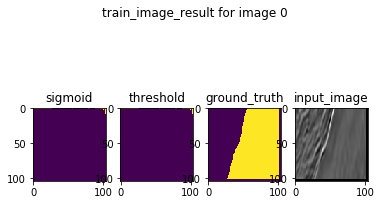

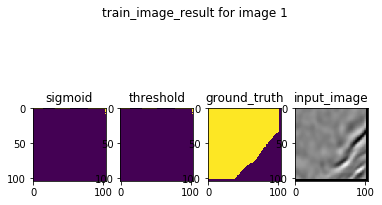

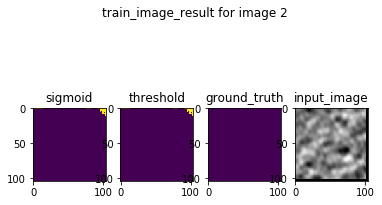

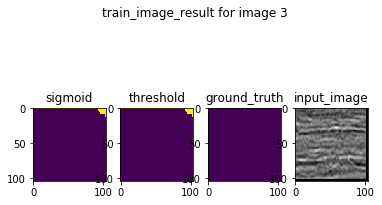

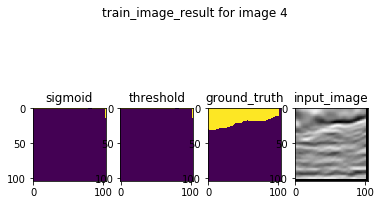

In [11]:
for i in range(5):
    proc_image(input_train, train, true_train, i, name = 'train_image_result')

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


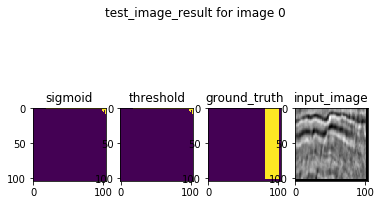

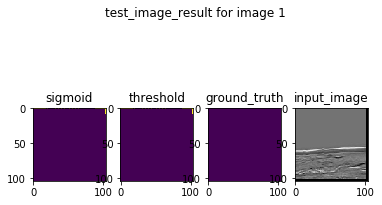

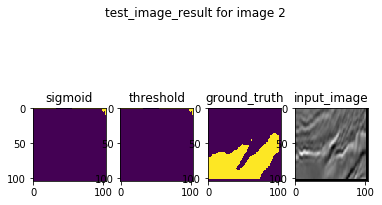

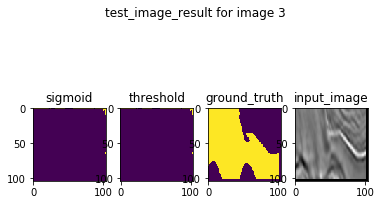

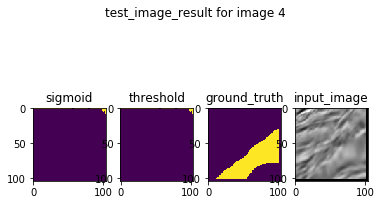

In [12]:
for i in range(5):
    proc_image(input_test, test, true_test, i, name = 'test_image_result')